<a href="https://colab.research.google.com/github/Dianacalvario/estadisticaverano/blob/main/TimeSeriesAnalysisU3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importar dataframe

# Importar dataframe si YF da error

In [ ]:
pip install alpha_vantage

In [ ]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Entra a https://www.alphavantage.co/support/#api-key
# Registrate para obtener tu api-key

# Tu clave de API (reemplaza esta por la tuya)
my_key = 'B4HOAASXNLT4JMJA'   # esta es mía, no la uses o habrá problemas

# Crear objeto TimeSeries
ts = TimeSeries(key=my_key, output_format='pandas')

# Obtener datos diarios de AMZN
ticker = 'AAPL'
data, meta = ts.get_daily(symbol=ticker, outputsize='full')

columnas = [ticker + '_' + i for i in ['Open', 'High', 'Low', 'Close', 'Volume']]
data.columns = columnas
#ANO-MES-DIA
inicio = '2024-07-24'
fin = '2025-07-20'
df = data[(data.index >= inicio) & (data.index <= fin)]

df

,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Volume
date,,,,,
2025-07-18,210.870,211.790,209.7045,211.18,48974591.0
2025-07-17,210.570,211.800,209.5900,210.02,48068141.0
2025-07-16,210.295,212.400,208.6400,210.16,47490532.0
2025-07-15,209.220,211.890,208.9200,209.11,42296339.0
2025-07-14,209.925,210.910,207.5400,208.62,38840111.0
...,...,...,...,...,...
2024-07-30,219.190,220.325,216.1200,218.80,41643840.0
2024-07-29,216.960,219.300,215.7500,218.24,36311778.0
2024-07-26,218.700,219.490,216.0100,217.96,41601345.0


# Medias móviles

# Prueba Dickey-Fuller Aumentada

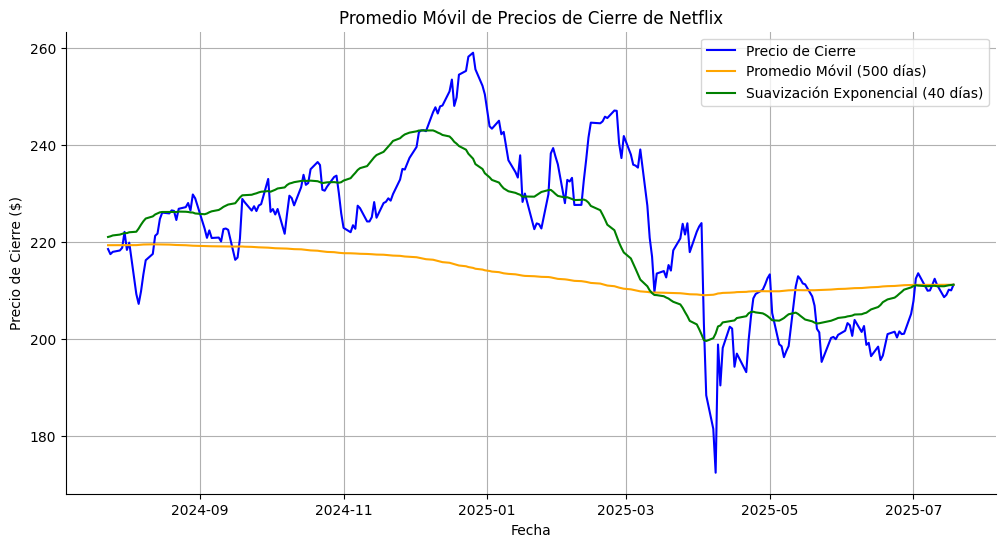

In [ ]:
# Promedio Móvil Simple
ventana_sma = 500
df['SMA'] = df['AAPL_Close'].ewm(span=ventana_sma, adjust=False).mean()

# Promedio Móvil Exponencial
ventana_ses = 40
df['SES'] = df['AAPL_Close'].ewm(span=ventana_ses, adjust=False).mean()

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df['AAPL_Close'], label='Precio de Cierre', color='blue')
plt.plot(df['SMA'], label=f'Promedio Móvil ({ventana_sma} días)', color='orange')
plt.plot(df['SES'], label=f'Suavización Exponencial ({ventana_ses} días)', color='green')
plt.title('Promedio Móvil de Precios de Cierre de Netflix')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.grid()
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [ ]:
#Prueba de estacionariedad: Prueba de Dickey-Fuller aumentada (ADF)

#Hipótesis nula (H₀): La serie tiene una raíz unitaria (no es estacionaria).
#Hipótesis alternativa (H₁): La serie es estacionaria.

from statsmodels.tsa.stattools import adfuller

nivel_de_significancia = 0.05

# Realizar la prueba de Dickey-Fuller en los la tendencia
adf_test = adfuller(df['AAPL_Close'].dropna()) # Realiza la prueba ADF


# Interpretación de la prueba ADF
print('Estadístico ADF:', adf_test[0])
print('p-value:', adf_test[1])

if adf_test[1] <= nivel_de_significancia:
    print("La tendencia es estacionaria (rechazamos la hipótesis nula).")
else:
    print("La tendencia no es estacionaria (aceptamos la hipótesis nula).")


Estadístico ADF: -1.9840909477518334
p-value: 0.29359193220515706
La tendencia no es estacionaria (aceptamos la hipótesis nula).


# Regresión polinomial

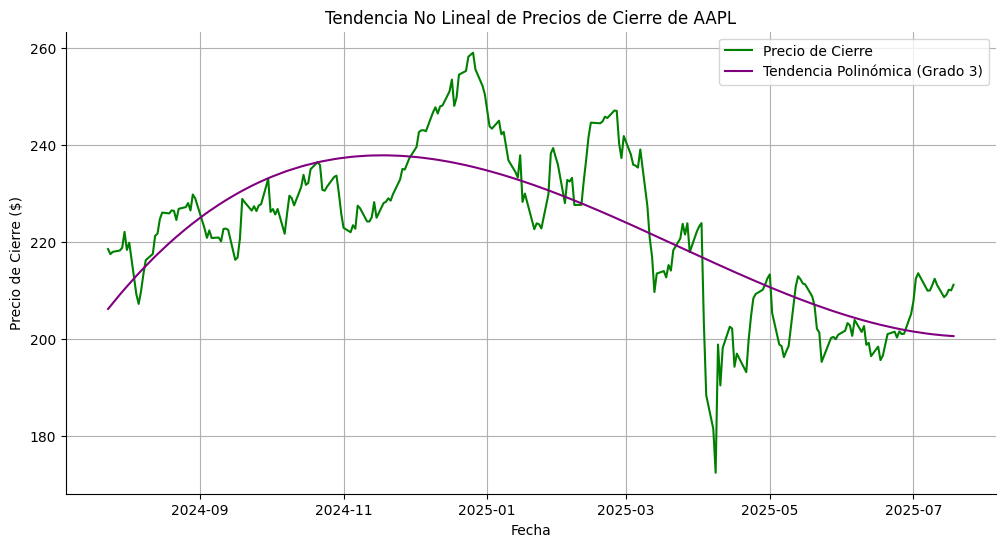

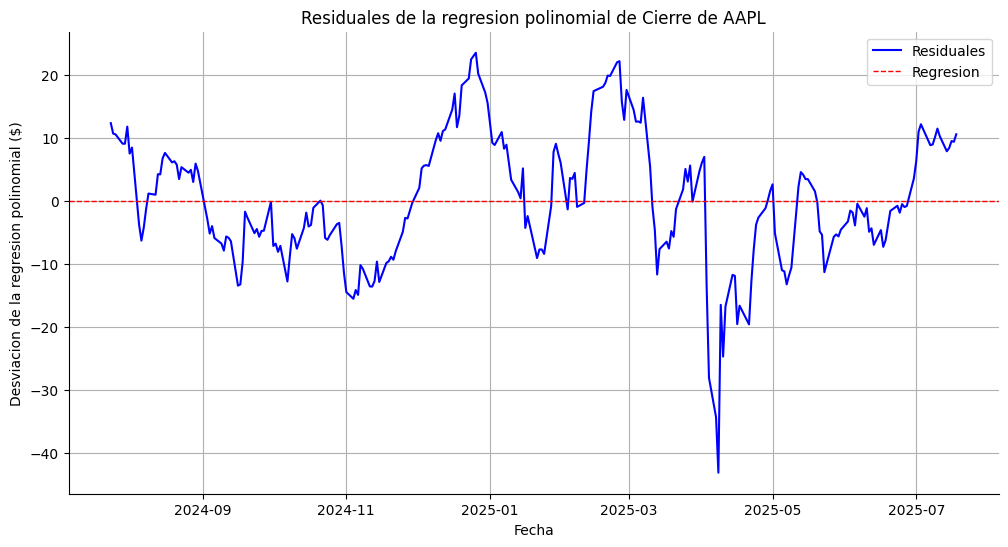

In [ ]:
from numpy.polynomial.polynomial import Polynomial

# Paso 1: Convertir fechas a números
# Creamos una nueva columna llamada 'Date' la cual contiene las fechas en
# segundos desde el 1 de de enero de 1970 (tiempo UNIX)
df['Date'] = pd.to_datetime(df.index).map(pd.Timestamp.timestamp)

# Paso 2: Definir las variables independientes (X) y la variable dependiente (y)
X = df['Date']
y = df['AAPL_Close']

# Paso 3: Ajustar un modelo polinómico
grado = 3
modelo = Polynomial.fit(X, y, deg = grado)
df['Poly_Trend'] = modelo(X)
df['Poly_Resid'] = y - df['Poly_Trend']

# Graficar polinomial
# abre una nueva ventana gráfica
plt.figure(
    figsize=(12, 6) # tamaño (horizontal, vertical)
    )

# qué se va a graficar:
plt.plot(
    y,
    label='Precio de Cierre', # etiqueta que aparecerá en la leyenda
    color='green'
    )

plt.plot(df['Poly_Trend'], label=f'Tendencia Polinómica (Grado {grado})', color='purple')
plt.title('Tendencia No Lineal de Precios de Cierre de AAPL') # Título
plt.xlabel('Fecha')                                           # nombre del eje x
plt.ylabel('Precio de Cierre ($)')                            # nombre del eje y
plt.legend()                                                  # agrega la leyenda
plt.grid()                                                    # agrega una cuadrícula
plt.gca().spines['top'].set_visible(False)                    # elimina los bordes superiores
plt.gca().spines['right'].set_visible(False)                  # elimina los bordes derechos
plt.show()                                                    # muestra el gráfico (innecesario en colab)




# Graficar los residuales del polinomio
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['Poly_Resid'], label='Residuales', color='blue')
plt.axhline(0, color='red', label='Regresion',linestyle='--', linewidth=1)  # Línea horizontal en el valor cero
plt.title('Residuales de la regresion polinomial de Cierre de AAPL')
plt.xlabel('Fecha')
plt.ylabel('Desviacion de la regresion polinomial ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

## Para Pros: Series de Fourier

Las series de Fourier descomponen cualquier cosa como una suma de senos y cosenos. Por esta razón, son una herramienta útil para extraer patrones oscilantes. Este es un tema muy complicado y alejado a todo lo que han manejado, por esta razón no les voy a pedir que lo usen. Aquí lo he simplificado tanto como he podido por si se animan.

In [ ]:
# Aquí no le muevan a nada
# Básicamente, lo que se hace este bloque es crear la función
# Transformada_de_Fourier, puesto a que no existe para lo que la quiero usar.

def Transformada_de_Fourier(serie, terminos, un_grafico):
  '''La función acepta los argumentos "serie", la cual debe de ser un array
  en numpy y en pandas de la forma df["my_variable"].values. Por otra parte,
  el parámetro "terminos" es un número natural que indica la cantidad de
  términos que desarrolla la serie. Entre mayor sea el número de términos,
  la serie será más precisa, pero más difícil de interpretar.

  La función tiene como salida una lista con los componentes sinosoidales de serie.
  El último elemento de la lista, es la suma de todos los componentes'''

  import numpy as np
  import matplotlib.pyplot as plt
  import pandas as pd
  from scipy.fftpack import fft, ifft

  # Supongamos que tienes una serie en df['AAPL_Close']
  # Reemplaza esta línea con tu DataFrame y serie específicos
  n = len(serie)

  # Calcular la transformada de Fourier
  transformada_fourier = fft(serie)

  # Obtener las frecuencias
  frecuencias = np.fft.fftfreq(n)

  # Crear un DataFrame para almacenar la frecuencia y su magnitud
  componentes = pd.DataFrame({
      'frecuencia': frecuencias,
      'magnitud': np.abs(transformada_fourier),
      'longitud_de_onda': 1 / frecuencias
  })

  # Ordenar el dataframe de mayor a menor en términos de magnitud

  componentes = componentes.sort_values(by='magnitud', ascending=False)

  # Seleccionar las frecuencias con mayor magnitud (excluyendo la frecuencia cero)
  top_frecuencias = componentes.loc[componentes['frecuencia'] > 0].nlargest(terminos, 'magnitud')
  top_frecuencias.reset_index(drop=True, inplace=True)
  print("Frecuencias principales:\n", top_frecuencias)

  # Crear el índice de tiempo para la serie
  t = np.arange(n)

  # Graficar cada componente de frecuencia junto con la serie original
  plt.figure(figsize=(12, 4))

  componente_temporal_sumado = np.zeros_like(serie)
  componentes_temporales = []

  n=0
  for i, row in top_frecuencias.iterrows():
      n+=1
      # Copiar la transformada de Fourier y mantener solo la frecuencia actual
      fourier_component = np.zeros_like(transformada_fourier)
      idx = np.where(frecuencias == row['frecuencia'])[0][0]  # índice de la frecuencia en la FFT
      fourier_component[idx] = transformada_fourier[idx]  # mantener solo la frecuencia positiva
      fourier_component[-idx] = transformada_fourier[-idx]  # mantener la frecuencia negativa correspondiente
      if n == (terminos+1):
        break

      # Reconstruir la señal en el tiempo
      componente_temporal = ifft(fourier_component).real
      componentes_temporales.append(componente_temporal)
      componente_temporal_sumado += componente_temporal

      # Graficar la componente
      plt.plot(
          componente_temporal,
          label=f'Longitud de onda {1 / row["frecuencia"]:.0f}',
          alpha=1,
          linewidth = 0.5,
          )
      plt.title('Componentes de Fourier de la Serie')
      plt.xlabel('Tiempo')
      plt.ylabel('Valor')
      plt.legend()
      plt.grid()

  componentes_temporales.append(componente_temporal_sumado)
  plt.plot(serie, label='Serie Original', color='black', alpha=0.5)
  if not un_grafico:
    plt.figure(figsize=(12, 4))
    plt.plot(serie, label='Serie Original', color='black', alpha=0.5)
  plt.plot(componente_temporal_sumado, label='Componente temporal sumada', color='red')
  plt.legend()
  plt.title('Suma de los Componentes de Fourier de la Serie')
  plt.xlabel('Tiempo')
  plt.ylabel('Valor')
  plt.grid()
  plt.show()

  return componentes_temporales

Frecuencias principales:
    frecuencia     magnitud  longitud_de_onda
0    0.008097  1083.809603        123.500000
1    0.020243   779.192341         49.400000
2    0.024291   421.181811         41.166667
3    0.048583   359.403726         20.583333
4    0.004049   290.178413        247.000000


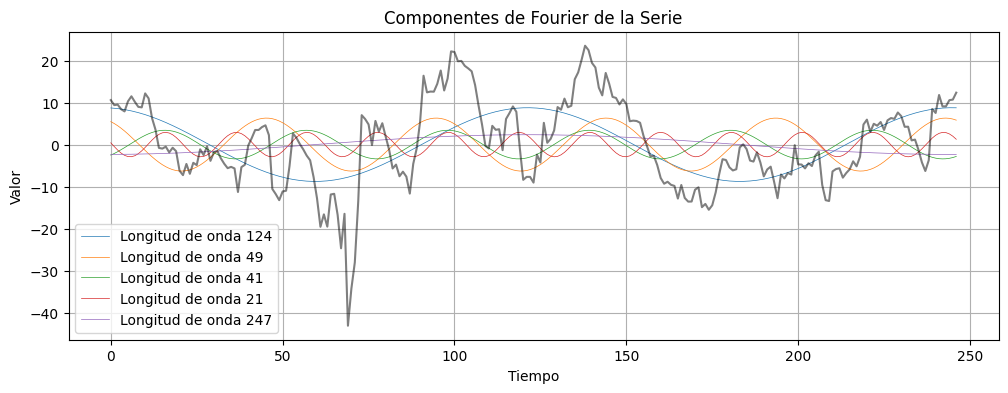

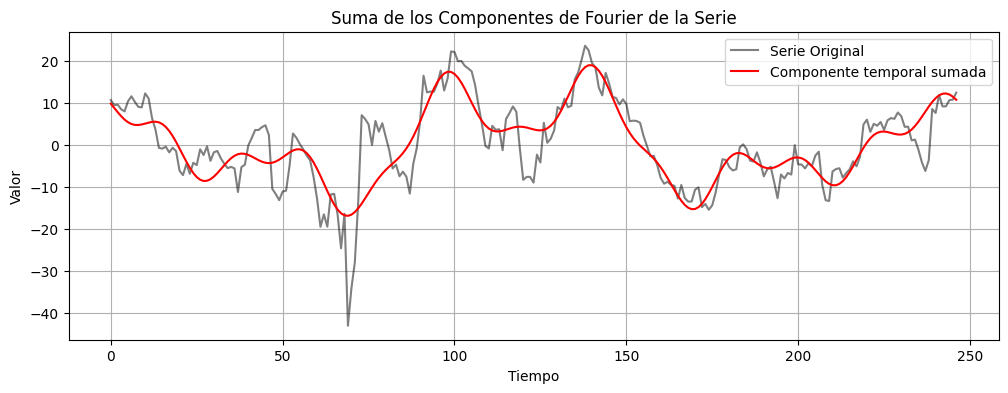

In [ ]:
serie = df['Poly_Resid'].values
terminos = 5
un_grafico = False

cts = Transformada_de_Fourier(serie, terminos, un_grafico)

# cts: componente temporal sumado


En estos gráficos, la longitud de onda equivale a la unidad de tiempo (en este caso, días) que tarda la onda en volver al mismo sitio. Algo que en nuestro contexto podríamos interpretar como estasionalidad. Vemos que la oscilación más grande se presenta cada 378 días. Dado que esto es más de un año, esto sería más bien un ciclo. Sin embargo, se puede apreciar algo muy interesante, la longitud de onda siguiente es de 126 en unidades de tiempo (días) que es justo la mitad de la cantidad de días de negociación en un año!!! 😯

# Descomposición de la serie

`sm.tsa.seasonal_descompose` descompone la serie de tiempo en los componentes Trend, Seasonal y Resid, que son Tendencia, Estacionalidad y Residuos, respectivamente. De tal manera que la serie de tiempo es igual la suma de estos tres elementos.

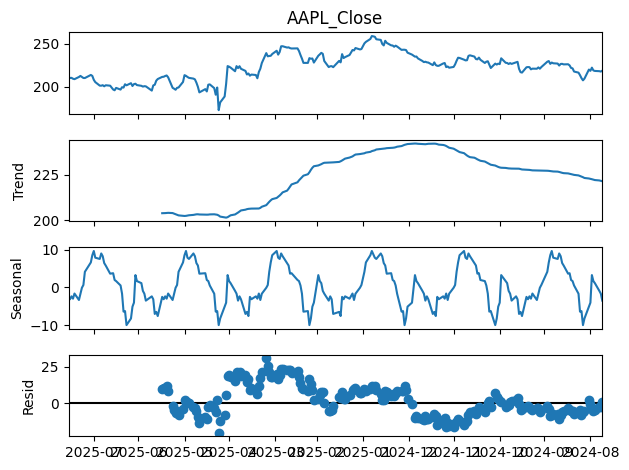

In [ ]:
# Descomponer la serie temporal
import statsmodels.api as sm

descomposicion = sm.tsa.seasonal_decompose(
    df['AAPL_Close'],
    model='additive',
    period=42,
    extrapolate_trend=0,
    two_sided=False,
    )  # 252 días de negociación al año
fig = descomposicion.plot()
plt.show()

In [ ]:
#Prueba de estacionariedad: Prueba de Dickey-Fuller aumentada (ADF)

#Hipótesis nula (H₀): La serie tiene una raíz unitaria (no es estacionaria).
#Hipótesis alternativa (H₁): La serie es estacionaria.

from statsmodels.tsa.stattools import adfuller

nivel_de_significancia = 0.05

# Realizar la prueba de Dickey-Fuller en los la tendencia
adf_test = adfuller(df['AAPL_Close'].dropna()) # Realiza la prueba ADF


# Interpretación de la prueba ADF
print('Estadístico ADF:', adf_test[0])
print('p-value:', adf_test[1])

if adf_test[1] <= nivel_de_significancia:
    print("La tendencia es estacionaria (rechazamos la hipótesis nula).")
else:
    print("La tendencia no es estacionaria (aceptamos la hipótesis nula).")

Estadístico ADF: -1.9840909477518334
p-value: 0.29359193220515706
La tendencia no es estacionaria (aceptamos la hipótesis nula).


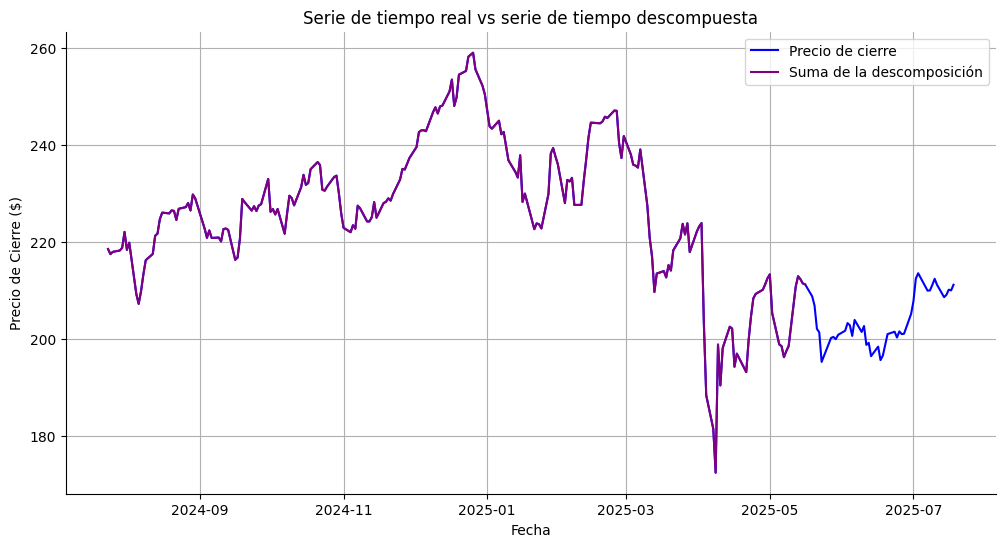

In [ ]:
# Graficar descomposición
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['AAPL_Close'], label='Precio de cierre', color='blue')
plt.plot(descomposicion.trend + descomposicion.seasonal + descomposicion.resid, label=f'Suma de la descomposición', color='purple')
plt.title('Serie de tiempo real vs serie de tiempo descompuesta')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

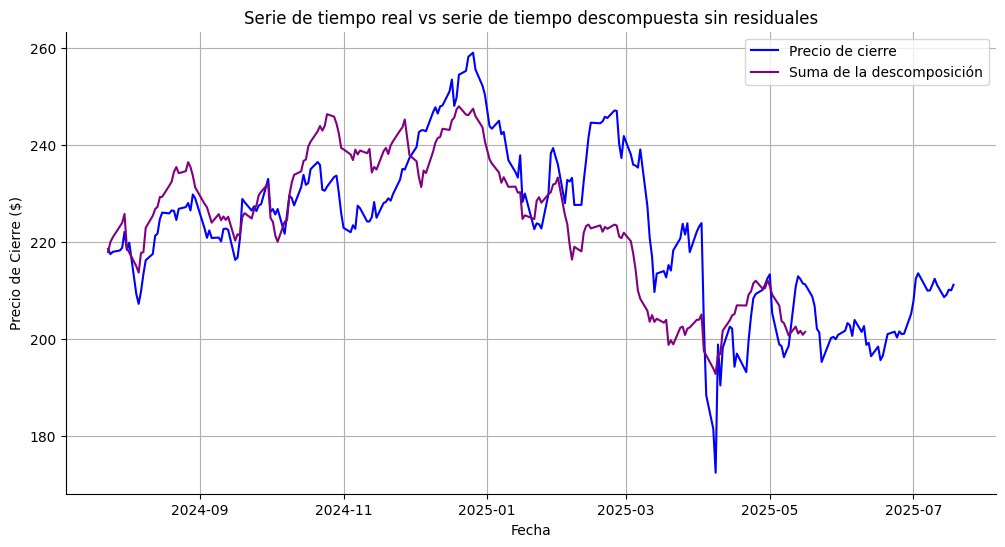

In [ ]:
# Graficar descomposición
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['AAPL_Close'], label='Precio de cierre', color='blue')
plt.plot(descomposicion.trend + descomposicion.seasonal, label=f'Suma de la descomposición', color='purple')
plt.title('Serie de tiempo real vs serie de tiempo descompuesta sin residuales')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

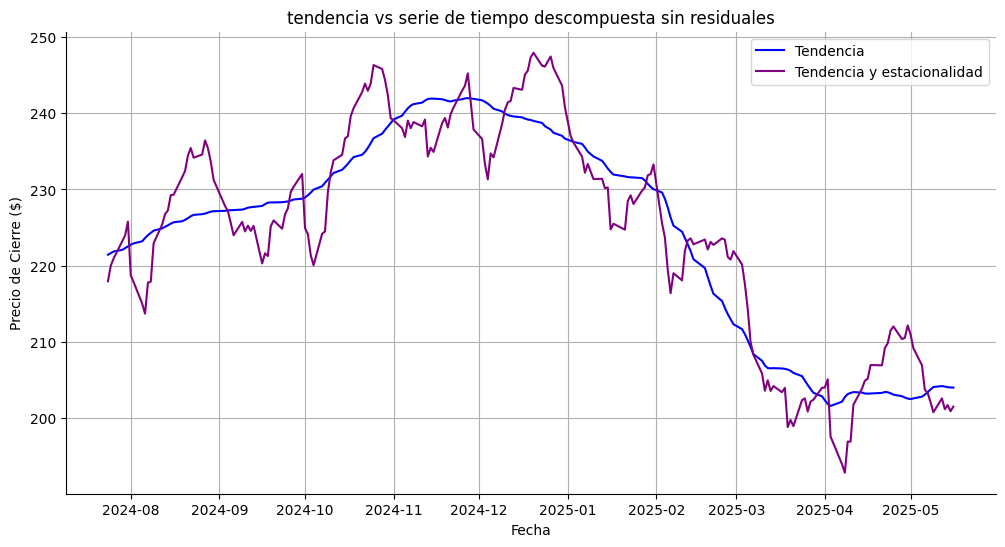

In [ ]:
# Graficar descomposición
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(descomposicion.trend, label='Tendencia', color='blue')
plt.plot(descomposicion.trend + descomposicion.seasonal, label=f'Tendencia y estacionalidad', color='purple')
plt.title('tendencia vs serie de tiempo descompuesta sin residuales')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

**Importante**: Es posible que hayan campturado bien la estacionalidad y que la prueba ADF de los residuales les indique que hay estacionariedad. Sin embargo, en el gráfico anterior vemos que no hay mucha diferencia entre la tendencia y la tendencia con estacionalidad. Por lo tanto, la estacionalidad, aunque existe, no es significativa. Esto se ilustra en el siguiente gráfico.

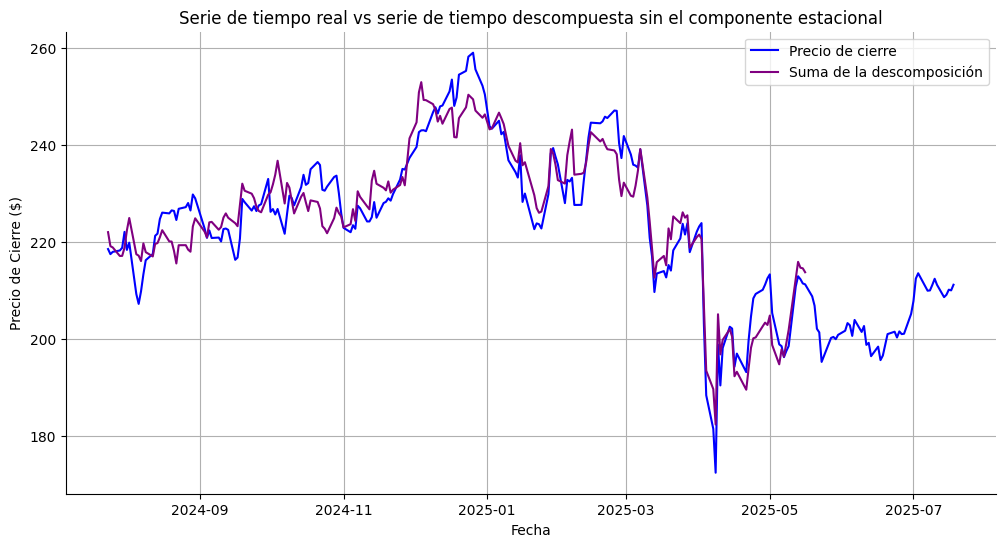

In [ ]:
# Graficar descomposición
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['AAPL_Close'], label='Precio de cierre', color='blue')
plt.plot(descomposicion.trend + descomposicion.resid, label=f'Suma de la descomposición', color='purple')
plt.title('Serie de tiempo real vs serie de tiempo descompuesta sin el componente estacional')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()